### Twitter ChatBot using Attention

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import (Input,LSTM,GRU,Dense,
                          Embedding,Bidirectional,RepeatVector,
                          Concatenate,Activation,Dot,Lambda)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

Using TensorFlow backend.


In [0]:
# function to do softmax over time
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e/s

In [0]:
# config variables
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256
LATENT_DIM_DECODER = 256
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [0]:
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [5]:
# load in the data
t = 0
for line in open('twitter_tab_format.txt'):
  t+=1
  if t>NUM_SAMPLES:
    break
  # input and target are seperated by '\t'
  if '\t' not in line:
    continue
  input_text, translation = line.split('\t')
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation
  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print('num samples:',len(input_texts))

num samples: 8490


In [0]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [7]:
# word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.'%len(word2idx_inputs))

Found 9908 unique input tokens.


In [0]:
# max length input seq
max_len_input = max(len(s) for s in input_sequences)

In [0]:
# tokenize the outputs
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [10]:
# word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.'%len(word2idx_outputs))

Found 14710 unique output tokens.


In [0]:
num_words_output = len(word2idx_outputs)+1
# max length output seq
max_len_target = max(len(s) for s in target_sequences)

In [12]:
# padding the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print('Encoder data shape:',encoder_inputs.shape)

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print('Decoder data shape:',decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

Encoder data shape: (8490, 34)
Decoder data shape: (8490, 33)


In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-08-11 05:50:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-11 05:50:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-11 05:50:26--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [14]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [15]:
# loading pre-trained word vectors
word2vec = {}
with open('glove.6B.%sd.txt'%EMBEDDING_DIM) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.'%len(word2vec))

Found 400000 word vectors.


In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
# creating embedding layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_len_input,
                            trainable=False)

In [0]:
decoder_targets_one_hot = np.zeros((len(input_texts),
                                   max_len_target,
                                   num_words_output),dtype='float32')
for i,d in enumerate(decoder_targets):
  for t,word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [0]:
# build the model
# setup the encoder
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, dropout=0.5))
encoder_outputs = encoder(x)

In [0]:
# setup the decoder
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [0]:
# Attention layer
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1)

In [0]:
def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])

  return context

In [0]:
# decoder after attention
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

In [0]:
initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [0]:
# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)
  
  # combine 
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)

In [0]:
# 'outputs' is now a list of length Ty
# each element is of shape [batch_size, output_vocab_size]
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape TxNxD
# we would like it to be of shape NxTxD

# so we stack and transpose
def stack_and_transpose(x):
  x = K.stack(x)
  x = K.permute_dimensions(x, pattern=(1, 0, 2))
  return x

In [0]:
# making it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

In [0]:
# create the model
model = Model(inputs=[encoder_inputs_placeholder,
                      decoder_inputs_placeholder,
                      initial_s,
                      initial_c],
              outputs=outputs)

In [0]:
# compile the model
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
z = np.zeros((len(encoder_inputs), LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2
)

W0811 05:51:44.933322 139707741038464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6792 samples, validate on 1698 samples
Epoch 1/100
6792/6792 [==============================] - 87s 13ms/step - loss: 3.0437 - acc: 0.6590 - val_loss: 2.6211 - val_acc: 0.6495
Epoch 2/100
6792/6792 [==============================] - 58s 9ms/step - loss: 2.3126 - acc: 0.6971 - val_loss: 2.5146 - val_acc: 0.6830
Epoch 3/100
6792/6792 [==============================] - 58s 8ms/step - loss: 2.1893 - acc: 0.7059 - val_loss: 2.4055 - val_acc: 0.6892
Epoch 4/100
6792/6792 [==============================] - 57s 8ms/step - loss: 2.1154 - acc: 0.7099 - val_loss: 2.3708 - val_acc: 0.6897
Epoch 5/100
6792/6792 [==============================] - 57s 8ms/step - loss: 2.0628 - acc: 0.7128 - val_loss: 2.3622 - val_acc: 0.6918
Epoch 6/100
6792/6792 [==============================] - 57s 8ms/step - loss: 2.0171 - acc: 0.7152 - val_loss: 2.3410 - val_acc: 0.6923
Epoch 7/100
6792/6792 [==============================] - 57s 8ms/step - loss: 1.9743 - acc: 0.7173 - val_loss: 2.3487 - val_acc: 0.6936

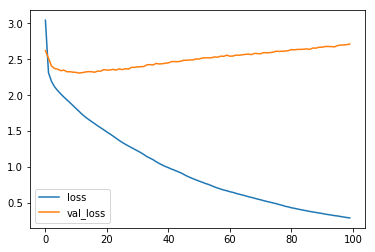

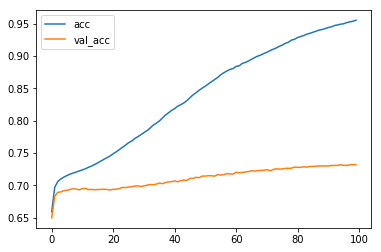

In [31]:
# plot the results
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'],label='acc')
plt.plot(r.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

In [0]:
## Make predictions
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM*2))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [0]:
context = one_step_attention(encoder_outputs_as_input, initial_s)
decoder_lstm_input = context_last_word_concat_layer([context,decoder_inputs_single_x])

In [0]:
o,s,c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s,initial_c])
decoder_outputs = decoder_dense(o)

In [0]:
decoder_model = Model(inputs=[decoder_inputs_single,
                              encoder_outputs_as_input,
                              initial_s,
                              initial_c],
                      outputs=[decoder_outputs, s, c])

In [0]:
# map indices back to real words
idx2word_eng = {v:k for k,v in word2idx_inputs.items()}
idx2word_trans = {v:k for k,v in word2idx_outputs.items()}

In [0]:
def decode_sequence(input_seq):
  enc_out = encoder_model.predict(input_seq)
  
  target_seq = np.zeros((1,1))
  target_seq[0,0] = word2idx_outputs['<sos>']
  
  eos = word2idx_outputs['<eos>']
  
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))
  
  # creating the translation
  output_sentence = []
  for _ in range(max_len_target):
    o,s,c = decoder_model.predict([target_seq, enc_out, s, c])
    
    idx = np.argmax(o.flatten())
    
    if eos==idx:
      break
      
    word = ''
    
    if idx>0:
      word = idx2word_trans[idx]
      output_sentence.append(word)
    
    target_seq[0,0] = idx
  
  return ' '.join(output_sentence)

In [40]:
i = np.random.choice(len(input_texts))
input_seq = encoder_inputs[i:i+1]
translation = decode_sequence(input_seq)
print('Input Sentence:',input_texts[i])
print('Predicted Translation:',translation)

Input Sentence: never thought i'd hear you say that since i feel you party all the time
Predicted Translation: i do more than just party i actually live here...i have family here...i work a normal job here...it's not all partying

